In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

In [25]:
symbols = [
    "ABEV3",
    "ARZZ3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
]

df = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") == datetime(2023, 12, 28))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()

# df["close"] = df["close"]*positions
# df.style.format({"close": "{:,.2f}", "volume": "{:,.2f}"})

df.pivot(index="refdate", columns="symbol", values="close").to_clipboard()

<Axes: >

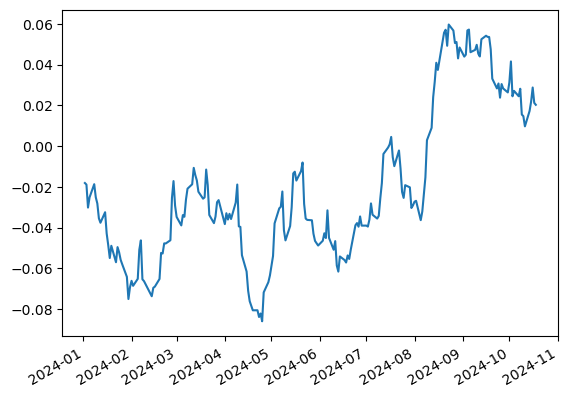

In [21]:
symbols = [
    "ABEV3",
    "AZZA3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
    "QBTC11",
    "ACWI11",
    "XFIX11",
]

positions = pd.Series([
    1300.0,
    300.0,
    1000.0,
    400.0,
    800.0,
    800.0,
    500.0,
    1732.5,
    1000.0,
    100.0,
    131.0,
    545.0,
    141.0,
], index=symbols)

df = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") == datetime(2024, 1, 5))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()

# df["close"] = df["close"]*positions
# df.style.format({"close": "{:,.2f}", "volume": "{:,.2f}"})

portfolio = df.pivot(index="refdate", columns="symbol", values="close") * positions

weights = portfolio / portfolio.sum(axis=1).iloc[0]
weights = weights.iloc[0]
weights.name = None

rets = brasa.get_returns(symbols, start=datetime(2024, 1, 1))

portfolio_returns = (rets * weights).sum(axis=1)

portfolio_returns.cumsum().plot()

In [18]:
display((np.exp(rets.sum().sort_values()) - 1) * 100)
(np.exp((rets.sum() * weights).sum()) - 1) * 100

B3SA3    -24.484709
EZTC3    -24.168154
AZZA3    -16.922819
ABEV3     -6.199415
INTB3     -5.591119
EGIE3     -3.667648
XFIX11    -2.810195
BBAS3      2.380715
ITSA4      7.787423
PSSA3     32.128844
ACWI11    38.996591
WEGE3     51.987232
QBTC11    77.285340
dtype: float64

2.050220278762338

In [16]:
portfolio.columns

Index(['ABEV3', 'ACWI11', 'ARZZ3', 'B3SA3', 'BBAS3', 'EGIE3', 'EZTC3', 'INTB3',
       'ITSA4', 'PSSA3', 'QBTC11', 'WEGE3', 'XFIX11'],
      dtype='object')

In [6]:
rets.std() * np.sqrt(252)

ABEV3     0.179808
ACWI11    0.123520
ARZZ3     0.351683
B3SA3     0.268565
BBAS3     0.162864
EGIE3     0.172986
EZTC3     0.400274
INTB3     0.337156
ITSA4     0.167378
PSSA3     0.216710
QBTC11    0.502231
WEGE3     0.250660
XFIX11    0.054641
dtype: float64

<Axes: >

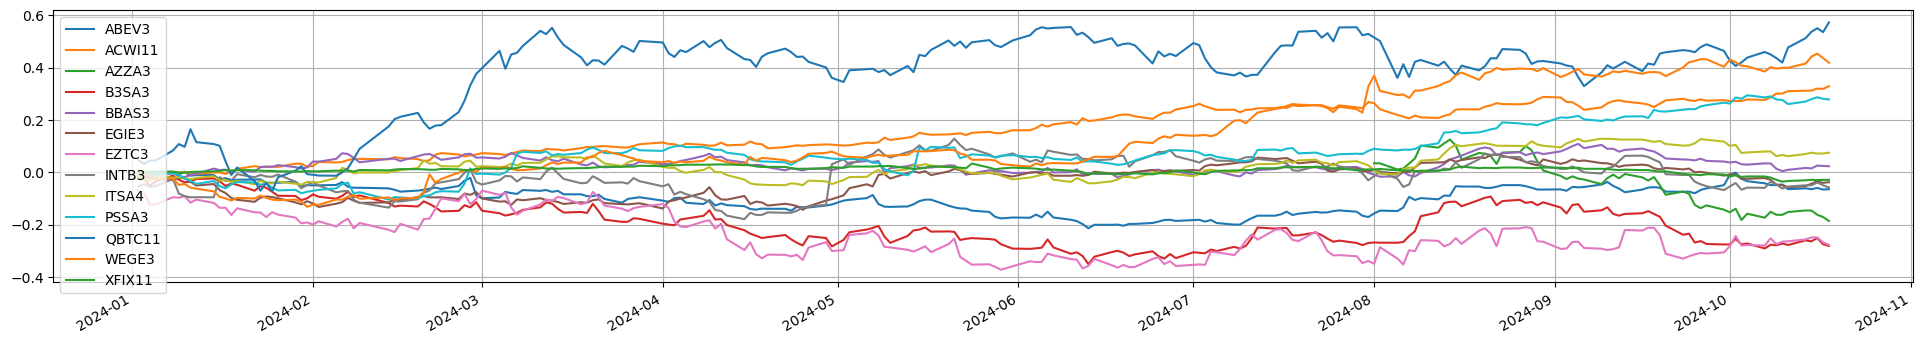

In [19]:
rets.cumsum().plot(grid=True, figsize=(24, 4))

In [8]:
portfolio_returns.std() * np.sqrt(252)

0.12445225147764802

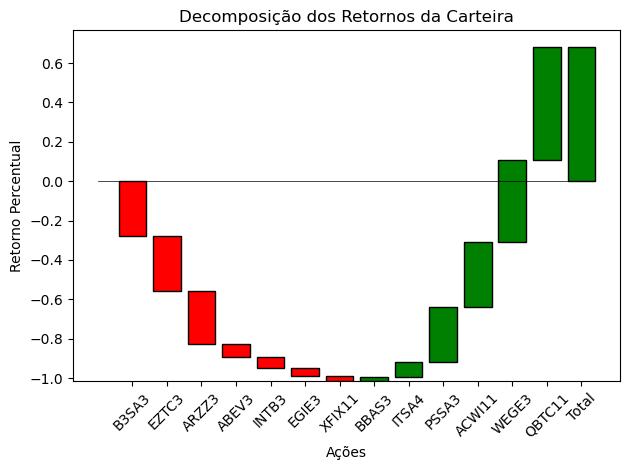

In [9]:
import matplotlib.pyplot as plt

# Exemplo de dados
retornos = rets.sum().sort_values()
acoes = retornos.index
retorno_carteira = rets.sum().sum()

# Cálculo do início de cada barra
start = 0
starts = [start]
for retorno in retornos[:-1]:
    start += retorno
    starts.append(start)

cores = ['green' if retorno >= 0 else 'red' for retorno in retornos]

# Criação do gráfico waterfall
fig, ax = plt.subplots()
for i, (acao, retorno, cor) in enumerate(zip(acoes, retornos, cores)):
    ax.bar(acao, retorno, bottom=starts[i], color=cor, edgecolor='black')

# Adicionar o retorno total com uma cor específica se for positivo ou negativo
cor_total = 'green' if retorno_carteira >= 0 else 'red'
ax.bar('Total', retorno_carteira, bottom=0, edgecolor='black', color=cor_total)

# Adiciona linhas para melhor visualização
ax.plot([-1, len(acoes)], [0, 0], color='black', linewidth=0.5)

# Configurações adicionais
ax.set_title('Decomposição dos Retornos da Carteira')
ax.set_ylabel('Retorno Percentual')
ax.set_xlabel('Ações')
plt.xticks(rotation=45)  # Rotação dos labels no eixo x para melhor visualização
plt.tight_layout()
plt.show()


In [ ]:
def backtest_quintis(df_precos, quintil, trade_dates, market_value):
    # Função que calcula o retorno de uma carteira de ações ao longo do tempo

    # Cria um dataframe com os preços percentuais de cada ação
    precos_perc = df_precos.pct_change(fill_method = None).fillna(0)
    datas_backtest = precos_perc.loc[trade_dates[0]:].index

    retorno_diario = pd.Series(index = precos_perc.index, name = 'Retorno diário')
    retorno_por_acao = pd.DataFrame(index = precos_perc.index, columns = precos_perc.columns)
    peso_diario = pd.DataFrame(index = precos_perc.index, columns = precos_perc.columns)
    
    for dt0 in datas_backtest[:-1]:
        date_location = datas_backtest.get_loc(dt0)
        dt1 = datas_backtest[date_location + 1]

        if dt0 in trade_dates:

            retorno_por_acao.loc[dt0] = (peso_diario.loc[dt0] * (precos_perc.loc[dt0]))
            retorno_diario.loc[dt0] = retorno_por_acao.loc[dt0].sum()
            dtm1 = datas_backtest[date_location - 1]
            peso_diario.loc[dt1] = calcula_pesos_direcional(quintil.loc[dtm1], dtm1, market_value, peso = 'igual', retornos = precos_perc)

        else:

            retorno_por_acao.loc[dt0] = (peso_diario.loc[dt0] * (precos_perc.loc[dt0]))
            retorno_diario.loc[dt0] = retorno_por_acao.loc[dt0].sum()
            peso_diario.loc[dt1] = (peso_diario.loc[dt0] * (1 + precos_perc.loc[dt0])) / (1 + retorno_diario.loc[dt0])

    retorno_por_acao.loc[dt1] = (peso_diario.loc[dt1] * (precos_perc.loc[dt1]))
    retorno_diario.loc[dt1] = retorno_por_acao.loc[dt1].sum()

    return retorno_por_acao

def backtest_longshort(df_precos, short_sig, long_sig, trade_dates, market_value):
    # Função que calcula o retorno de uma carteira de ações ao longo do tempo

    # Cria um dataframe com os preços percentuais de cada ação
    precos_perc = df_precos.pct_change(fill_method = None).fillna(0)
    datas_backtest = precos_perc.loc[trade_dates[0]:].index

    retorno_diario = pd.Series(index = precos_perc.index, name = 'Retorno diário')
    retorno_por_acao = pd.DataFrame(index = precos_perc.index, columns = precos_perc.columns)
    peso_diario = pd.DataFrame(index = precos_perc.index, columns = precos_perc.columns)
    
    for dt0 in datas_backtest[:-1]:
        date_location = datas_backtest.get_loc(dt0)
        dt1 = datas_backtest[date_location + 1]

        if dt0 in trade_dates:

            retorno_por_acao.loc[dt0] = (peso_diario.loc[dt0] * (precos_perc.loc[dt0]))
            retorno_diario.loc[dt0] = retorno_por_acao.loc[dt0].sum()
            dtm1 = datas_backtest[date_location - 1]
            peso_diario.loc[dt1] = calcula_pesos_longshort(short_sig.loc[dtm1], long_sig.loc[dtm1], dtm1, market_value, peso = 'igual', retornos = precos_perc)

        else:

            retorno_por_acao.loc[dt0] = (peso_diario.loc[dt0] * (precos_perc.loc[dt0]))
            retorno_diario.loc[dt0] = retorno_por_acao.loc[dt0].sum()
            peso_diario.loc[dt1] = (peso_diario.loc[dt0] * (1 + precos_perc.loc[dt0])) / (1 + retorno_diario.loc[dt0])

    retorno_por_acao.loc[dt1] = (peso_diario.loc[dt1] * (precos_perc.loc[dt1]))
    retorno_diario.loc[dt1] = retorno_por_acao.loc[dt1].sum() 

    return retorno_por_acao